In [1]:
import pathlib
import numpy as np
import plotly.express as px
import pandas as pd

In [43]:
meta_df = None

In [44]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["econ"] = go.layout.Template(
layout = {
    # Fonts
    # Note - 'family' must be a single string, NOT a list or dict!
    'title':
        {'font': {'family': 'Roboto Condensed, bold', 
                  'size':24,
                  'color': '#333'}
        },
    'font': {'family': 'Roboto Condensed', 
                  'size':18,
                  'color': '#333'},
    # Colorways
    #'colorway': ['#ec7424', '#a4abab'],
    # Keep adding others as needed below
    'margin': {'l':20, 'r':20, 't':140, 'b':20},
    'paper_bgcolor':"#fff5e6",
    'width':1600,
    'height': 900,
    },
)
pio.templates["econ"].layout.autosize = False

px.defaults.template = "ggplot2+econ"

In [51]:
wd = pathlib.Path("../../../Data/Run_JP/outputs/")
wd = pathlib.Path("../../../Data/Run_GER/outputs/")
wd = pathlib.Path("../../../Data/Floods_Run_1/")
#df = pd.read_excel("./../../../Data/Données_SocioEco/Tableaux/aggreg EXIO.ods", sheet_name="input", engine="odf", header=None).to_numpy()
#df = pd.read_csv(wd/"indicators_20220221-1536.csv")
#df = pd.read_csv(wd/"indicators_20220221-1226.csv")
df = pd.read_excel(wd/"indicators_pre_treated.ods", engine = "odf")

df = df[['region', 'tot_fd_unmet', 'aff_fd_unmet', 'shortage_b', 'prod_gain_tot',
    'prod_lost_tot', 'prod_gain_unaff', 'prod_lost_unaff', 'q_dmg']]

df = df.melt(id_vars=['region', 'shortage_b', 'q_dmg'])
#df = df.drop(0)
df
#px.Scatter(df, x='q_dmg', y="")

,region,shortage_b,q_dmg,variable,value
0,AT,False,8.339840e+09,tot_fd_unmet,7702.519691
1,AT,False,2.259885e+09,tot_fd_unmet,2502.390351
2,AT,False,2.906845e+08,tot_fd_unmet,313.895706
3,AU,True,3.931253e+10,tot_fd_unmet,946464.448591
4,AU,False,3.349392e+09,tot_fd_unmet,4445.148105
...,...,...,...,...,...
697,US,False,1.249970e+09,prod_lost_unaff,0.488005
698,US,False,9.789872e+07,prod_lost_unaff,0.017968
699,ZA,True,2.245920e+09,prod_lost_unaff,2061.157093
700,ZA,False,1.647764e+06,prod_lost_unaff,0.000354


In [52]:
#meta_df = df[df.variable=="tot_fd_unmet"]
meta_df = meta_df.append(df[df.variable=="tot_fd_unmet"])

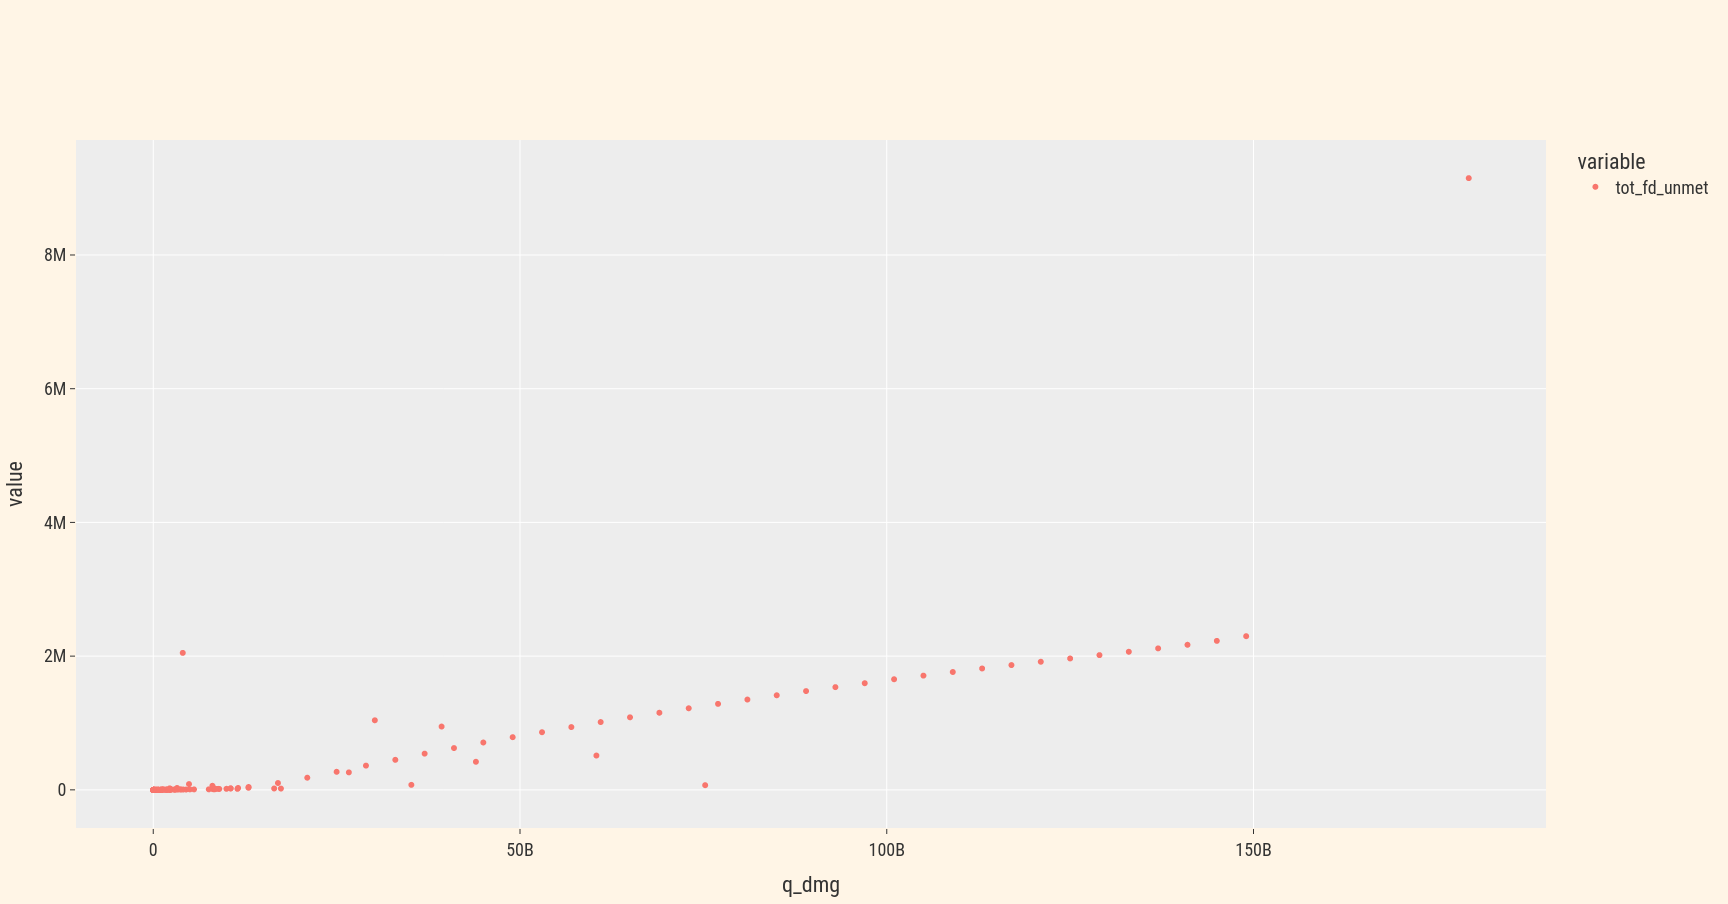

In [54]:
fig = px.scatter(meta_df, x='q_dmg', y='value', color="variable", hover_data=["region"])
fig.show()